In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.transforms import (
    Activations,
    AddChannel,
    AsChannelFirst,
    AsDiscrete,
    Compose,
    EnsureType,
    LoadImage,
    RandFlip,
    RandSpatialCrop,
    RandZoom,
    Resize,
    ScaleIntensity,
    ScaleIntensityRange,
    SpatialCrop,
    ToTensor,
)
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
import monai.utils as utils

import torch

import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np

import itk

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
img1_dir = "../../Data/VFoldData/ROIData/"

all_images = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.overlay.nii.gz')))

num_classes = 2

num_slices = 48

num_workers_te = 0
batch_size_te = 1

model_filename_base = "BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold"

num_images = len(all_images)

print(num_images)

num_folds = 15

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
fold_label_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
train_labels = []
val_files = []
val_labels = []
test_files = []
test_labels = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    img = [im for im in all_images if any(pref in im for pref in tr_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    train_files.append(img)
    train_labels.append(seg)
    img = [im for im in all_images if any(pref in im for pref in va_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    val_files.append(img)
    val_labels.append(seg)
    img = [im for im in all_images if any(pref in im for pref in te_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    test_files.append(img)
    test_labels.append(seg)
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))
    print(len(train_labels[i]),len(val_labels[i]),len(test_labels[i]))

108
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 0]
94 6 8
94 6 8
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0]
91 8 9
91 8 9
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1,

In [3]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AsChannelFirst(),
        ARGUS_RandSpatialCropSlices(
            num_slices=num_slices,
            axis=0,
            reduce_to_statistics=True),
        ScaleIntensity(
            channel_wise=True),
        RandFlip(prob=0.5, 
            spatial_axis=1),
        RandZoom(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode='bilinear'),
        EnsureType(),
    ]
)

val_transforms = Compose(
    [
        LoadImage(image_only=True), 
        AsChannelFirst(),
        ARGUS_RandSpatialCropSlices(
            num_slices=num_slices,
            axis=0,
            center_slice=30,
            reduce_to_statistics=True),
        ScaleIntensity(), 
        EnsureType()
    ]
)

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

In [4]:
class PTXDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [5]:
test_ds = [PTXDataset(test_files[i], test_labels[i], None) for i in range(num_folds)]
test_loader = [torch.utils.data.DataLoader(test_ds[i], batch_size=batch_size_te, shuffle=False, num_workers=num_workers_te) 
                for i in range(num_folds)]

In [6]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:1")

In [21]:
def plot_vfold_training_curves(vfold_num, test_loader, graph):
    if graph:
        print("   VFOLD =", vfold_num, "of", num_folds)
    
    correct = 0
    incorrect = 0
    
    slice_correct = 0
    slice_incorrect = 0
    
    false_negatives = 0
    slice_false_negatives = 0
    
    loss_file = model_filename_base+"_loss_"+str(vfold_num)+".npy"
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
        
        metric_file = model_filename_base+"_auc_"+str(vfold_num)+".npy"
        metric_values = np.load(metric_file)
    
        if graph:
            plt.figure("train", (12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Epoch Average Loss")
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            #plt.ylim([0.2,0.8])
            plt.subplot(1, 2, 2)
            plt.title("Val Mean Dice")
            x = [2 * (i + 1) for i in range(len(metric_values))]
            y = metric_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            #plt.ylim([0.2,0.8])
            plt.show()
    
    model_file = model_filename_base+'_'+str(vfold_num)+'.pth'
    print(model_file)
    if os.path.exists(model_file):
        model = DenseNet121(spatial_dims=2, in_channels=2,
                            out_channels=num_classes).to(device)
        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), 1e-5)
        auc_metric = ROCAUCMetric()
        model.load_state_dict(torch.load(model_file))
        model.eval()
        i = 0
        fname = os.path.basename(test_files[vfold_num][i]["image"])
        prevfname = fname
        count1 = 0
        count = 0
        with torch.no_grad():
            for b,test_data in enumerate(test_loader):
                timages, tlabels = (
                    test_data[0].to(device),
                    test_data[1].to(device),
                )
                y_pred = model(timages)
                y = tlabels
                y_onehot = y_trans(y)
                y_pred_act = y_pred_trans(y_pred)
                print(y_pred, y_pred_act, y, y_onehot)

                diff = 0
                for c in range(num_classes):
                    diff += (y_onehot[i][c] - y_pred_act[i][c])**2
                result = float(diff)
                print("   Diff =", diff)
                acc_value = abs(y_pred.argmax(dim=0) - y)
                print("   Acc value =", acc_value)
                
                prevfname = fname
                fname = os.path.basename(test_files[vfold_num][i]["image"])
                
                if fname[:4]!=prevfname[:4]:
                    if graph:
                        print(prevfname[:4], "Counts per class = ", count1)
                    if count1 == count:
                        if graph:
                            print("  Winner = Sliding")
                        if y == 1:
                            correct += 1
                        else:
                            incorrect += 1
                            false_negatives += 1
                            print("FN Patient =", prevfname)
                    else:
                        if graph:
                            print("  Winner = Not Sliding")
                        if y == 0:
                            correct += 1
                        else:
                            incorrect += 1
                            print("FP Patient =", prevfname)
                    if graph:
                        print()
                        print()
                    count1 = 0
                    count = 0
                    
                if acc_value == 0:
                    count1 += 1
                    slice_correct += 1
                else:
                    slice_incorrect += 1
                    if y == 1:
                        slice_false_negatives += 1
                        print("   FN ROI =", fname)
                count += 1

                if graph:
                    print(fname)

                    plt.figure("check", (18, 6))
                    plt.subplot(1, 3, 1)
                    plt.title(f"image {i}")
                    tmpV = test_data["image"][j, 1, :, :]
                    plt.imshow(tmpV, cmap="gray")
                    print("Idea = ", y, "  Predicted = ", y_pred_act)
                    plt.show()

                    print("Number of sliding pixel =", slice_count1)
                    if slice_count1>min_thresh:
                        print("   Sliding")
                    else:
                        print("   NOT Sliding")
                    print()
                    print()

                    for c in range(num_classes):
                        arrimg = test_outputs.detach().cpu()[j,c,:,:]
                        itkimg = itk.GetImageFromArray(arrimg)
                        filename = "prob_f"+str(b)+"_i"+str(j)+"_c"+str(c)+".mha"
                        itk.imwrite(itkimg, filename)

                i += 1
                    
            if graph:
                print(prevfname[:4], "Counts per class = ", count1)
            if count1 == count:
                if graph:
                    print("  Winner = Sliding")
                if prevfname[3] == 's':
                    correct += 1
                else:
                    incorrect += 1
                    false_negatives += 1
                    print("FN Patient =", fname)
            else:
                if graph:
                    print("  Winner = Not Sliding")
                if prevfname[3] == 'n':
                    correct += 1
                else:
                    incorrect += 1
                    print("FP Patient =", fname)
            if graph:
                print()
                print()
                
    return correct, incorrect, false_negatives, slice_correct, slice_incorrect, slice_false_negatives

   VFOLD = 0 of 15


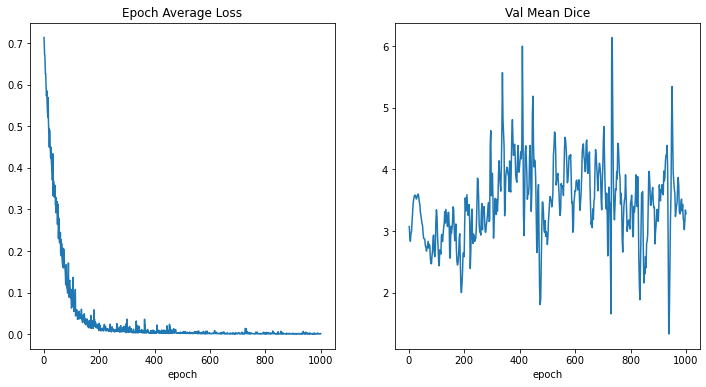

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_0.pth
   VFOLD = 1 of 15


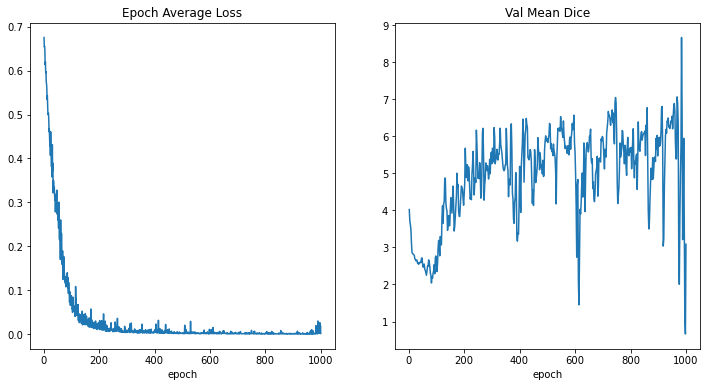

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_1.pth
   VFOLD = 2 of 15


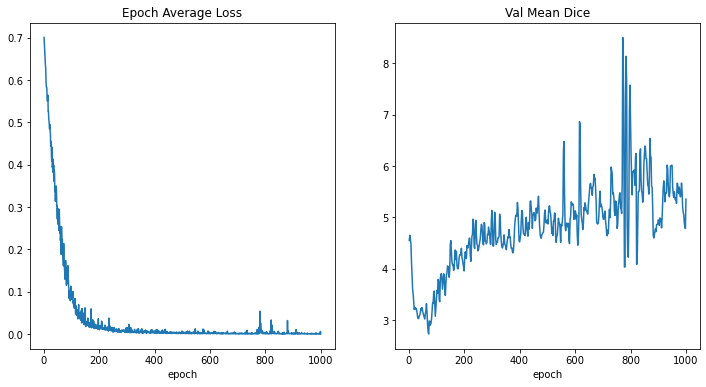

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_2.pth
   VFOLD = 3 of 15


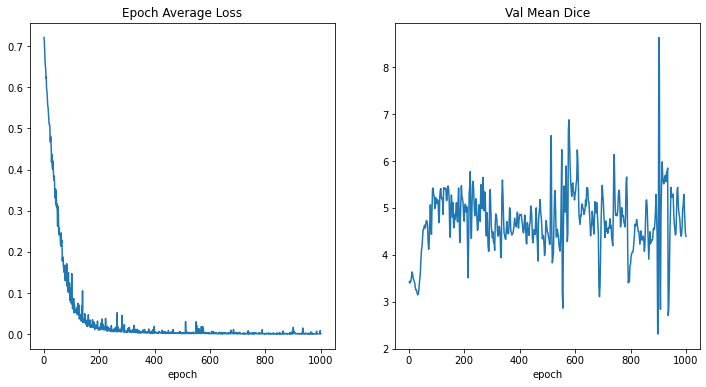

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_3.pth
   VFOLD = 4 of 15


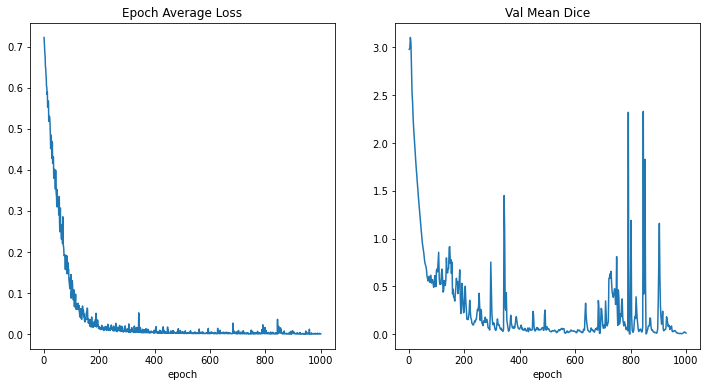

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_4.pth
   VFOLD = 5 of 15


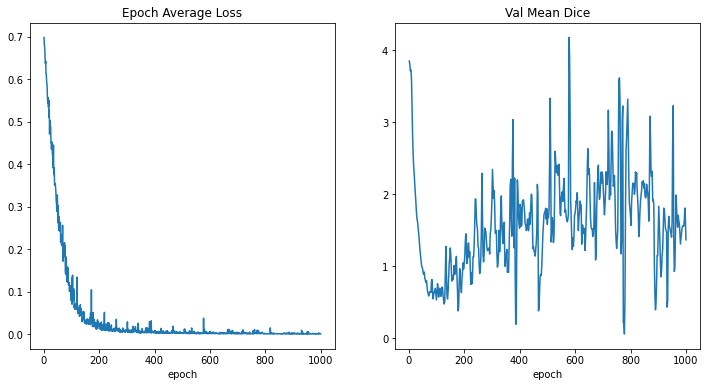

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_5.pth
   VFOLD = 6 of 15


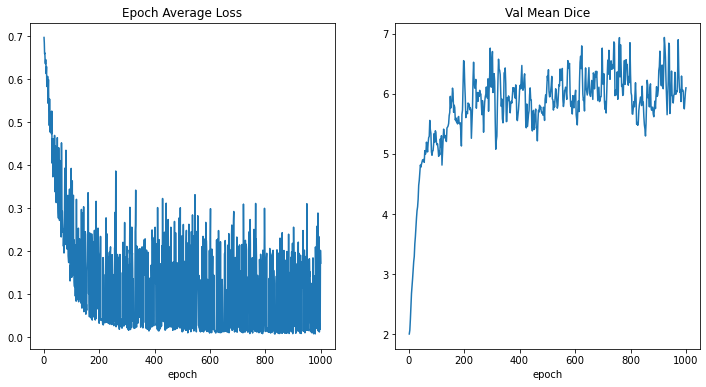

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_6.pth
   VFOLD = 7 of 15


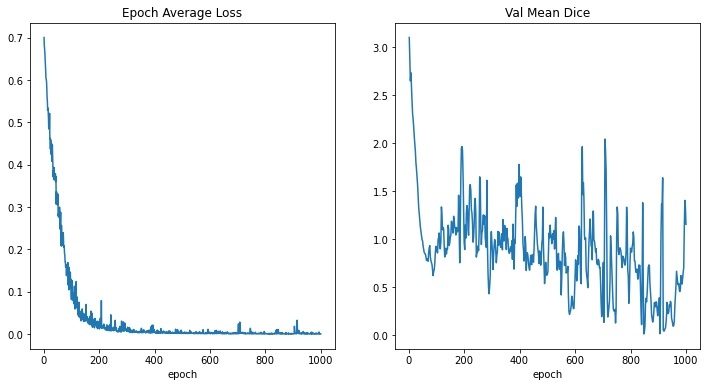

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_7.pth
   VFOLD = 8 of 15


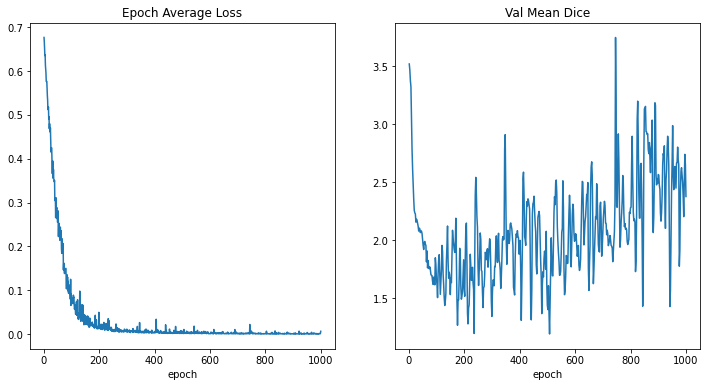

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_8.pth
   VFOLD = 9 of 15


KeyboardInterrupt: 

In [22]:
correct = 0
incorrect = 0
false_negatives = 0
slice_correct = 0
slice_incorrect = 0
slice_false_negatives = 0
for i in range(num_folds):
    (fcorrect, fincorrect, ffalse_negatives, fslice_correct,
     fslice_incorrect, fslice_false_negatives) = plot_vfold_training_curves(i, test_loader[i], True)
    correct += fcorrect
    incorrect += fincorrect
    false_negatives += ffalse_negatives
    slice_correct += fslice_correct
    slice_incorrect += fslice_incorrect
    slice_false_negatives += fslice_false_negatives
print("   Patients: Correct =", correct, "Incorrect =", incorrect, "Not Sliding as Sliding =", false_negatives)
print("     Slices: Correct =", slice_correct, "Incorrect = ", slice_incorrect, "Not Sliding as Sliding =", slice_false_negatives)